In [1]:
import numpy as np
import sw_lib as sw
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
plt.style.use('../plots/paper.mplstyle') #Use custom stylesheet
import pandas as pd
import ks_custom as ksc
import sklearn as skl
import scipy.stats as sps
from scipy.special import erf as errorfunc
from scipy.special import erfinv as errorfuncinv
import sw_scripts as sws

datapath = '../data/' #Path to data
modelpath = '../modelstore/' #Path to models/hyperparameters
plotpath = '../plots/' #Path to plot storage

#Fix Random Seed
seed = 888 #Lucky!
np.random.seed(seed) #Seed the NP generator

#Color and style
c1 = '#E76F51'
c2 = '#F4A261'
c3 = '#E9C46A'
c4 = '#2A9D8F'
c5 = '#264653'
r = '#B7094C'
b = '#0091AD'

taikonaut_colors = [(38/255.0, 70/255.0, 83/255.0),
                  (42/255.0, 157/255.0, 143/255.0),
                  (233/255.0, 196/255.0, 106/255.0),
                  (244/255.0, 162/255.0, 97/255.0),
                  (231/255.0, 111/255.0, 81/255.0)]
taikonaut = LinearSegmentedColormap.from_list('taikonaut', taikonaut_colors, N=10000)

new_oranges_colors = [(253/255.0, 240/255.0, 237/255.0),
                      (220/255.0, 60/255.0, 24/255.0)]
new_oranges = LinearSegmentedColormap.from_list('new_oranges', new_oranges_colors, N=10000)

new_greens_colors = [(239/255.0, 251/255.0, 249/255.0),
                     (33/255.0, 131/255.0, 114/255.0)]
new_greens = LinearSegmentedColormap.from_list('new_greens', new_greens_colors, N=10000)

rb_colors = [(183/255.0, 9/255.0, 76/255.0),
             (137/255.0, 43/255.0, 100/255.0),
             (92/255.0, 77/255.0, 125/255.0),
             (0/255.0, 145/255.0, 173/255.0)]
rb = LinearSegmentedColormap.from_list('rb', rb_colors, N=10000)

In [2]:
#Target Dataset
mms_data = pd.read_hdf(datapath + 'mms_data.h5', key = 'old_targets', mode = 'a')
mms_data = ksc.nightside_cut(mms_data, conesize = np.pi/2) #Cut out the nightside data since classification is unreliable there
mms_data.loc[:, ['R_xgse', 'R_ygse', 'R_zgse']] /= 6378 #Scale to Earth Radii
mms_sw = mms_data.drop(mms_data[mms_data['region']!=2].index) #Solar Wind Data
mms_sh = mms_data.drop(mms_data[mms_data['region']!=1].index) #Magnetosheath Data
#mms_sw = mms_sw[mms_sw['Vi_xgse'] <= -250] #Cut out erroneous super slow solar wind (maybe it's the magnetosheath?)

#Input Datatset
wind_data = pd.read_hdf(datapath + 'wind_data.h5', key = 'inputs', mode = 'a')
wind_sw_ind = ksc.closest_argmin(mms_sw['Epoch'].to_numpy(), wind_data['Epoch'].to_numpy()) #Get the indices of the wind dataset closest to each target time

#Split up and scale the datasets
in_keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ni', 'Vth', 'R_xgse', 'R_ygse', 'R_zgse', 'target_R_xgse', 'target_R_ygse', 'target_R_zgse'] #Wind data keys to include in input dataset
tar_keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ne'] #Targets from MMS dataset to match
window = 60 #Input window length (100s units)
stride = 15 #Stride away from target (100s units)
inter_frac = 5/60 #How many interpolated points in a row to tolerate
flag = 'tdelt' #Whether to cut inputs as a percent of total or length of maximum interpolated stretch of data
ds = ksc.load_dataset(datapath + 'mms_data.h5', datapath + 'wind_data.h5', 'sw', in_keys, tar_keys, split_frac=0.2, window=window, stride=stride, inter_frac=int(inter_frac*window), flag=flag, tar_storekey = 'old_targets', conesize = np.pi/2, vx_cut=False)

mms_cut = mms_sw[ds.ds_mask]
mms_train = mms_cut.iloc[ds.inds_train]
mms_test = mms_cut.iloc[ds.inds_test]

#Load saved model outputs (old_outputs.h5)
predict_test = pd.read_hdf(datapath + 'old_outputs.h5', key = 'prime_predict_test', mode = 'a')
predict = pd.read_hdf(datapath + 'old_outputs.h5', key = 'prime_predict', mode = 'a')
predict_full = pd.read_hdf(datapath + 'old_outputs.h5', key = 'prime_predict_full', mode = 'a')
predict_bs = pd.read_hdf(datapath + 'old_outputs.h5', key = 'prime_predict_bs', mode = 'a')
predict_test[['R_xgse', 'R_ygse', 'R_zgse']] = mms_test[['R_xgse', 'R_ygse', 'R_zgse']]

#Load OMNI data and select the test set
omni_full = pd.read_hdf(datapath + 'wind_data.h5', key = 'wind_omni_shift', mode = 'a') #load shifted omni data
omni_test = omni_full.iloc[ksc.closest_argmin(mms_test['Epoch'].to_numpy(), omni_full['Epoch'].to_numpy())] #cut omni so it's just the test set
cut_test = ((omni_test.index.duplicated()) | (omni_test['Timeshift_mms']>100)) #Cut out bad data
omni_test.loc[cut_test, omni_test.columns!='Epoch'] = np.nan #Set bad data to nan
omni_test.index = mms_test.index #Set the index to the mms test set index for ease of comparison
omni_test.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ne'}, inplace = True) #Rename columns to match mms_test

omni_sw = omni_full.iloc[ksc.closest_argmin(mms_sw['Epoch'].to_numpy(), omni_full['Epoch'].to_numpy())] #cut omni so it's just when MMS data is available to compare
cut_sw = ((omni_sw.index.duplicated()) | (omni_sw['Timeshift_mms']>100)) #Cut out bad data
omni_sw.loc[cut_sw, omni_sw.columns!='Epoch'] = np.nan #Set bad data to nan
omni_sw.index = mms_sw.index #Set the index to the mms test set index for ease of comparison
omni_sw.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ne'}, inplace = True) #Rename columns to match mms_test

C:\Users\conno\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a cop

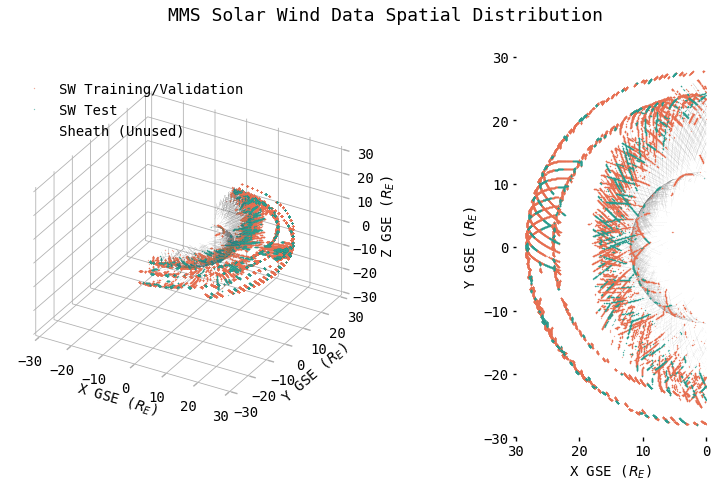

In [3]:
#Plot the MMS solar wind data in 3D
fig = plt.figure(figsize=(16,7))
fig.suptitle('MMS Solar Wind Data Spatial Distribution', fontsize = 18)
ax = fig.add_subplot(121, projection='3d')
ax.plot(mms_train['R_xgse'], mms_train['R_ygse'], mms_train['R_zgse'], '.', markersize = 0.5, c = c1, label = 'SW Training/Validation')
ax.plot(mms_test['R_xgse'], mms_test['R_ygse'], mms_test['R_zgse'], '.', markersize = 0.5, c = c4, label = 'SW Test')
ax.plot(mms_sh['R_xgse'], mms_sh['R_ygse'], mms_sh['R_zgse'], '.',  alpha = 0.02, markersize = 0.5, c = 'grey', label = 'Sheath (Unused)')
ax.set_proj_type('ortho')
#Make 3d scatter facecolor white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#Remove 3d scatter axis lines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

#ax.plot(wind_data['Px_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Py_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Pz_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, '.', markersize = 0.5, c = c1, label = 'Wind Inputs')
ax.set_xlabel('X GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='x', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_ylabel('Y GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='y', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_zlabel('Z GSE ($R_{E}$)', fontsize = 14)
ax.tick_params(axis='z', labelsize=14, color="#b0b0b0", width = 0.4)
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)
ax.legend(fontsize = 14, loc = 'upper left')

ax2 = fig.add_subplot(122)
ax2.plot(mms_sh['R_ygse'], mms_sh['R_xgse'], '.', c = 'grey', alpha = 0.02, markersize = 0.5)
ax2.plot(mms_train['R_ygse'], mms_train['R_xgse'], '.', c = c1, markersize = 0.5)
ax2.plot(mms_test['R_ygse'], mms_test['R_xgse'], '.', c = c4, markersize = 0.5)
ax2.set_aspect('equal')
ax2.set_ylim(0, 30)
ax2.set_ylabel(r'X GSE ($R_{E}$)')
ax2.set_xlim(30, -30)
ax2.set_xlabel(r'Y GSE ($R_{E}$)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#plt.savefig('../plots/mms_sw_3d_test.png', bbox_inches = 'tight', dpi = 300)

In [4]:
def crps_func(mu, sg, y):
    ep = np.abs(y - mu)
    crps = sg * ((ep/sg) * errorfunc(ep/(np.sqrt(2)*sg)) + np.sqrt(2/np.pi) * np.exp(-ep**2 / (2*sg**2)) - 1/np.sqrt(np.pi))
    return crps

def crps_min_f(mu, y):
    '''
    Helper function that calculates min continuous rank probability scores
    '''
    ep = np.abs(y - mu)
    N = len(ep)
    crps_min = (np.sqrt(np.log(4.0))/(2*N)) * np.sum(ep)
    return crps_min

mms_test['pdyn'] = sw.pdyn(mms_test['Ne'], mms_test['Vi_xgse'])
mms_train['pdyn'] = sw.pdyn(mms_train['Ne'], mms_train['Vi_xgse'])
mms_sw['pdyn'] = sw.pdyn(mms_sw['Ne'], mms_sw['Vi_xgse'])
omni_test['pdyn'] = sw.pdyn(omni_test['Ne'], omni_test['Vi_xgse'])
predict_test['pdyn'] = sw.pdyn(predict_test['Ne'], predict_test['Vi_xgse'])
predict_test['pdyn_sig'] = sw.pdyn_err(predict_test['Ne'], predict_test['Vi_xgse'], predict_test['Ne_sig'], predict_test['Vi_xgse_sig'])
mms_test['B'] = np.sqrt(mms_test['B_ygsm']**2 + mms_test['B_zgsm']**2)
omni_test['B'] = np.sqrt(omni_test['B_ygsm']**2 + omni_test['B_zgsm']**2)
predict_test['B'] = np.sqrt(predict_test['B_ygsm']**2 + predict_test['B_zgsm']**2)
predict_test['B_sig'] = sw.mag_err(0, 0, predict_test['B_ygsm'], predict_test['B_ygsm_sig'], predict_test['B_zgsm'], predict_test['B_zgsm_sig'])
mms_test['theta'] = np.arctan2(mms_test['B_ygsm'], mms_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the MMS data
omni_test['theta'] = np.arctan2(omni_test['B_ygsm'], omni_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the OMNI data
predict_test['theta'] = np.arctan2(predict_test['B_ygsm'], predict_test['B_zgsm']) * 180/np.pi #Calculate the IMF clock angle for the predicted data
predict_test['theta_sig'] = sw.theta_err(predict_test['B_ygsm'], predict_test['B_ygsm_sig'], predict_test['B_zgsm'], predict_test['B_zgsm_sig']) #Calculate the uncertainty in the IMF clock angle for the predicted data


keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ne', 'pdyn'] #Keys for the data parameters to be compared
keys_sig = [key+'_sig' for key in keys]
labels = ['Bx (nT)', 'By (nT)', 'Bz (nT)', 'Vx (km/s)', 'Vy (km/s)', 'Vz (km/s)', 'n (cm$^{-3}$)', '$P_{dyn}$ (nPa)'] #Labels for the data parameters to be compared
omni_error = np.abs(omni_test[keys] - mms_test[keys]) #Calculate the CRPS (MAE for deterministic predictions) between the omni and mms test sets
omni_error_min = crps_min_f(omni_test[keys], mms_test[keys]) #Calculate the minimum possible CRPS betweenn the omni and mms test sets
predict_error = crps_func(predict_test[keys], predict_test[keys_sig].to_numpy(), mms_test[keys]) #Calculate the CRPS between the predicted and mms test sets
predict_error_min = crps_min_f(predict_test[keys], mms_test[keys]) #Calculate the minimum possible CRPS between the predicted and mms test sets
omni_error['Epoch'] = pd.to_datetime(mms_test['Epoch'], unit='s', utc=True) #Add the time column back in
predict_error['Epoch'] = pd.to_datetime(mms_test['Epoch'], unit='s', utc=True) #Add the time column back in
print('OMNI CRPS:\n', np.mean(np.abs(omni_error[keys]), axis = 0)) #Print the CRPS for each parameter
print('OMNI Min CRPS:\n', omni_error_min) #Print the minimal CRPS for each parameter
print('PRIME CRPS:\n', np.mean(np.abs(predict_error[keys]), axis = 0)) #Print the CRPS for each parameter
print('PRIME Min CRPS:\n', predict_error_min) #Print the minimal CRPS for each parameter

OMNI CRPS:
 B_xgsm      1.126413
B_ygsm      1.711704
B_zgsm      1.559399
Vi_xgse    16.159592
Vi_ygse     8.768646
Vi_zgse     6.865979
Ne          2.155455
pdyn        0.547208
dtype: float64
OMNI Min CRPS:
 B_xgsm     0.299558
B_ygsm     0.455210
B_zgsm     0.414706
Vi_xgse    3.024685
Vi_ygse    1.641279
Vi_zgse    1.285145
Ne         0.403449
pdyn       0.102424
dtype: float64
PRIME CRPS:
 B_xgsm     0.874863
B_ygsm     1.099871
B_zgsm     1.069606
Vi_xgse    9.226511
Vi_ygse    5.226108
Vi_zgse    4.094049
Ne         0.850163
pdyn       0.198942
dtype: float64
PRIME Min CRPS:
 B_xgsm     0.703929
B_ygsm     0.833513
B_zgsm     0.853029
Vi_xgse    6.626479
Vi_ygse    3.991441
Vi_zgse    3.287747
Ne         0.684519
pdyn       0.158695
dtype: float64


c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

MMS Slow SW Density: 8.286979 Speed: -361.8203430175781
MMS Fast SW Density: 1.9866222 Speed: -632.9219360351562
PRIME Slow SW Density: 8.49703598022461 +/- 1.3463058471679688 CRPS:  0.3276734548818818
PRIME Fast SW Density: 1.6382534503936768 +/- 0.6537256240844727 CRPS:  0.22512984647586445


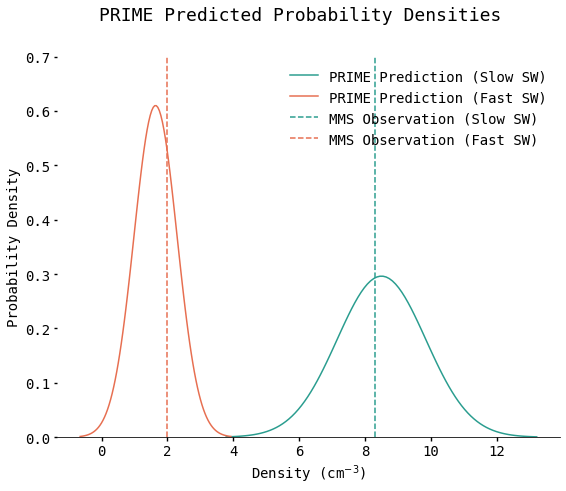

In [42]:
i_slow = 241883
i_fast = 102468
#Plot predict_test gaussians from predicted density for slow and fast solar wind
def gaussian(mu, sig):
    x = np.linspace(mu - 3.5*sig, mu + 3.5*sig, 100)
    y = np.exp(-(x-mu)**2/(2*sig**2))/(np.sqrt(2*np.pi)*sig)
    return x, y
fig = plt.figure(figsize=(7,7))
fig.suptitle('PRIME Predicted Probability Densities', fontsize = 18)
ax = fig.add_subplot(111)
x_slow, y_slow = gaussian(predict_test['Ne'][i_slow], predict_test['Ne_sig'][i_slow])
x_fast, y_fast = gaussian(predict_test['Ne'][i_fast], predict_test['Ne_sig'][i_fast])
ax.plot(x_slow, y_slow, c = c4, label = 'PRIME Prediction (Slow SW)')
ax.plot(x_fast, y_fast, c = c1, label = 'PRIME Prediction (Fast SW)')
ax.axvline(mms_test['Ne'][i_slow], c = c4, linestyle = '--', label = 'MMS Observation (Slow SW)')
ax.axvline(mms_test['Ne'][i_fast], c = c1, linestyle = '--', label = 'MMS Observation (Fast SW)')
ax.set_ylim(0,0.7)
ax.set_xlabel('Density (cm$^{-3}$)', fontsize = 14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel('Probability Density', fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize = 14, loc = 'upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#plt.savefig('../plots/predicted_gaussian.pdf', bbox_inches = 'tight')
print('MMS Slow SW Density:', mms_test['Ne'][i_slow], 'Speed:', mms_test['Vi_xgse'][i_slow])
print('MMS Fast SW Density:', mms_test['Ne'][i_fast], 'Speed:', mms_test['Vi_xgse'][i_fast])
print('PRIME Slow SW Density:', predict_test['Ne'][i_slow], '+/-', predict_test['Ne_sig'][i_slow], 'CRPS: ', predict_error['Ne'][i_slow])
print('PRIME Fast SW Density:', predict_test['Ne'][i_fast], '+/-', predict_test['Ne_sig'][i_fast], 'CRPS: ', predict_error['Ne'][i_fast])

In [ ]:
nbins = 50
keys = ['B_xgsm', 'B_ygsm', 'B_zgsm', 'Vi_xgse', 'Vi_ygse', 'Vi_zgse', 'Ne', 'pdyn'] #Keys for the data parameters to be compared
bounds = [[-10, 10], [-10, 10], [-10, 10], [-700, -250], [-60, 60], [-60, 60],[0,30],[0,13]]
titles = [r'$B_{X}$ GSE',r'$B_{Y}$ GSE',r'$B_{Z}$ GSE',r'$V_{X}$ GSE',r'$V_{Y}$ GSE',r'$V_{Z}$ GSE', 'n', r'$P_{dyn}$']
units = ['nT','nT','nT','km/s','km/s','km/s',r'$cm^{-3}$','nPa']
fig, ax = plt.subplots(nrows=4,ncols=4)
fig.set_size_inches(21, 21)
plt.subplots_adjust(hspace = 0.3, wspace=0.2)
for idx, key in enumerate(keys):
    #PRIME in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[idx//4,idx%4].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(1e0, 1e3), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_greens)
    ax[idx//4,idx%4].tick_params(axis='both', which='major')
    ax[idx//4,idx%4].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_aspect('equal')
    ax[idx//4,idx%4].set_xlabel('Target ('+units[idx]+')')
    ax[idx//4,idx%4].set_ylabel('PRIME ('+units[idx]+')')
    ax[idx//4,idx%4].set_title(titles[idx], fontsize = 14)
    ax[idx//4,idx%4].autoscale(enable=False)
    ax[idx//4,idx%4].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[idx//4,idx%4].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n MAE: ' + str(model_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//4,idx%4].transAxes, color = 'k', fontsize = 14)
    #ax[idx//4,idx%4].text(.48, .07, 'Bin Max: ' + str(im1.get_clim()[1])[0:5], ha='left', va='top', transform = ax[idx//4,idx%4].transAxes, color = 'k', fontsize = 14)
    
    #OMNI in the bottom
    pred_temp = omni_test[key].dropna()
    mms_temp = mms_test[key][pred_temp.index]
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im2 = ax[idx//4+2,idx%4].hexbin(mms_temp, pred_temp, gridsize = nbins, norm=LogNorm(1e0, 3e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_oranges)
    ax[idx//4+2,idx%4].tick_params(axis='both', which='major')
    ax[idx//4+2,idx%4].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//4+2,idx%4].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//4+2,idx%4].set_aspect('equal')
    ax[idx//4+2,idx%4].set_xlabel('Target ('+units[idx]+')')
    ax[idx//4+2,idx%4].set_ylabel('MVA Wind ('+units[idx]+')')
    ax[idx//4+2,idx%4].set_title(titles[idx], fontsize = 14)
    ax[idx//4+2,idx%4].autoscale(enable=False)
    ax[idx//4+2,idx%4].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    omni_mae = np.mean(np.abs(pred_temp.to_numpy() - mms_temp.to_numpy()))
    omni_r, omni_p = sps.pearsonr(pred_temp.to_numpy(), mms_temp.to_numpy())
    ax[idx//4+2,idx%4].text(.01, .99, ' CRPS/MAE: ' + str(omni_mae)[0:5] + ' '+units[idx]+'\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[idx//4+2,idx%4].transAxes, color = 'k', fontsize = 14)
    #ax[idx//4+2,idx%4].text(.48, .07, 'Bin Max: ' + str(im2.get_clim()[1])[0:5], ha='left', va='top', transform = ax[idx//4+2,idx%4].transAxes, color = 'k', fontsize = 14)
#Put colorbar for im1 on the right of the first two rows
cbar_ax = fig.add_axes([0.90, 0.527, 0.01, 0.35])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#Put colorbar for im2 on the right of the last two rows
cbar_ax = fig.add_axes([0.90, 0.127, 0.01, 0.35])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#plt.savefig('../plots/prime_omni.pdf', bbox_inches='tight')

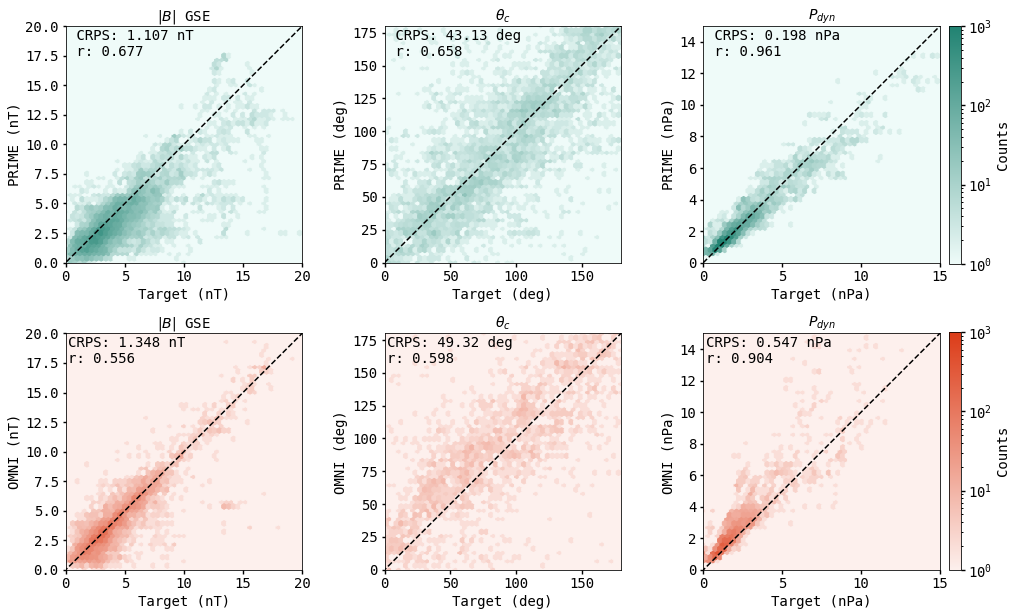

In [9]:
standard_err = (predict_test[keys] - mms_test[keys])/(np.sqrt(2) * predict_test[keys_sig].to_numpy()) #Standard error for each parameter
phi = np.linspace(0,1,1000) #Observed probabily axis
cumulative_dist = np.zeros((len(phi), len(keys))) #Cumulative distribution for each parameter
for idx, key in enumerate(keys):
    for i in standard_err[key].index:
        cumulative_dist[:,idx] += (1/len(standard_err[key])) * np.heaviside(phi - 0.5*(errorfunc(standard_err.loc[i,key])+1) , 1) #Calculate the cumulative distribution for each parameter
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(7,9))
color_arr = taikonaut(np.linspace(0,1,8)) #Color array for each parameter
ax[0].plot(phi, cumulative_dist[:,0], label = r'$B_{x}$ GSM', c = color_arr[0])
ax[0].plot(phi, cumulative_dist[:,1], label = r'$B_{y}$ GSM', c = color_arr[1])
ax[0].plot(phi, cumulative_dist[:,2], label = r'$B_{z}$ GSM', c = color_arr[2])
ax[0].plot(phi, cumulative_dist[:,3], label = r'$V_{x}$ GSE', c = color_arr[3])
ax[0].plot(phi, cumulative_dist[:,4], label = r'$V_{y}$ GSE', c = color_arr[4])
ax[0].plot(phi, cumulative_dist[:,5], label = r'$V_{z}$ GSE', c = color_arr[5])
ax[0].plot(phi, cumulative_dist[:,6], label = 'n', c = color_arr[6])
ax[0].plot(phi, cumulative_dist[:,7], label = r'$P_{dyn}$', c = color_arr[7])
#Place legend to the right middle of the figure
ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
ax[0].plot(phi, phi, linestyle = '--', color = 'k')
ax[0].set_ylabel('Observed Frequency')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
fig.suptitle('Reliability Diagram')

ax[1].plot(phi, phi - cumulative_dist[:,0], label = r'$B_{x}$ GSM', c = color_arr[0])
ax[1].plot(phi, phi - cumulative_dist[:,1], label = r'$B_{y}$ GSM', c = color_arr[1])
ax[1].plot(phi, phi - cumulative_dist[:,2], label = r'$B_{z}$ GSM', c = color_arr[2])
ax[1].plot(phi, phi - cumulative_dist[:,3], label = r'$V_{x}$ GSE', c = color_arr[3])
ax[1].plot(phi, phi - cumulative_dist[:,4], label = r'$V_{y}$ GSE', c = color_arr[4])
ax[1].plot(phi, phi - cumulative_dist[:,5], label = r'$V_{z}$ GSE', c = color_arr[5])
ax[1].plot(phi, phi - cumulative_dist[:,6], label = 'n', c = color_arr[6])
ax[1].plot(phi, phi - cumulative_dist[:,7], label = r'$P_{dyn}$', c = color_arr[7])
ax[1].plot(phi, np.zeros(len(phi)), linestyle = '--', color = 'k')
ax[1].set_ylim(-0.15,0.15)
ax[1].set_xlabel('Predicted Frequency')
ax[1].set_ylabel('Under/Over-\nEstimation')
ax[1].set_aspect('equal')
plt.subplots_adjust(hspace = -0.20)

#plt.savefig('../plots/reliability_diagram.pdf', bbox_inches='tight')

In [ ]:
#Plot the joint distributions for derived parameters
nbins = 50
derived_keys = ['B', 'theta', 'pdyn']
bounds = [[0, 20], [0, 180], [0, 15]]
titles = [r'$|B|$ GSE',r'$\theta_{c}$',r'$P_{dyn}$']
units = ['nT','deg','nPa']
fig, ax = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(16, 10)
plt.subplots_adjust(hspace = 0.3, wspace=0.25)
for idx, key in enumerate(derived_keys):
    #GRU in the top half
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im1 = ax[0,idx].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_greens)
    ax[0,idx].tick_params(axis='both', which='major')
    ax[0,idx].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[0,idx].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[0,idx].set_aspect('equal')
    ax[0,idx].set_xlabel('Target ('+units[idx]+')')
    ax[0,idx].set_ylabel('PRIME ('+units[idx]+')')
    ax[0,idx].set_title(titles[idx], fontsize = 14)
    ax[0,idx].autoscale(enable=False)
    ax[0,idx].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    model_crps = np.mean(crps_func(predict_test[key].to_numpy(), predict_test[key+'_sig'].to_numpy(), mms_test[key].to_numpy()))
    #model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[0,idx].text(.01, .99, ' CRPS: ' + str(model_crps)[0:5] + ' '+units[idx]+'\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[0,idx].transAxes, color = 'k', fontsize = 14)
    
    #OMNI in the bottom
    pred_temp = omni_test[key].dropna()
    mms_temp = mms_test[key][pred_temp.index]
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im2 = ax[1,idx].hexbin(mms_temp, pred_temp, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]), cmap=new_oranges)
    ax[1,idx].tick_params(axis='both', which='major')
    ax[1,idx].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[1,idx].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[1,idx].set_aspect('equal')
    ax[1,idx].set_xlabel('Target ('+units[idx]+')')
    ax[1,idx].set_ylabel('OMNI ('+units[idx]+')')
    ax[1,idx].set_title(titles[idx], fontsize = 14)
    ax[1,idx].autoscale(enable=False)
    ax[1,idx].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='k',linestyle='--')
    omni_mae = np.mean(np.abs(pred_temp.to_numpy() - mms_temp.to_numpy()))
    omni_r, omni_p = sps.pearsonr(pred_temp.to_numpy(), mms_temp.to_numpy())
    ax[1,idx].text(.01, .99, 'CRPS: ' + str(omni_mae)[0:5] + ' '+units[idx]+'\nr: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[1,idx].transAxes, color = 'k', fontsize = 14)
#Put colorbar for im1 on the right of the first row
cbar_ax = fig.add_axes([0.90, 0.55, 0.01, 0.33])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#Put colorbar for im2 on the right of the last row
cbar_ax = fig.add_axes([0.90, 0.125, 0.01, 0.33])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Counts', fontsize = 14)
cbar.ax.tick_params(labelsize=14)
#plt.savefig('../plots/prime_omni_derived.pdf', bbox_inches='tight')

c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


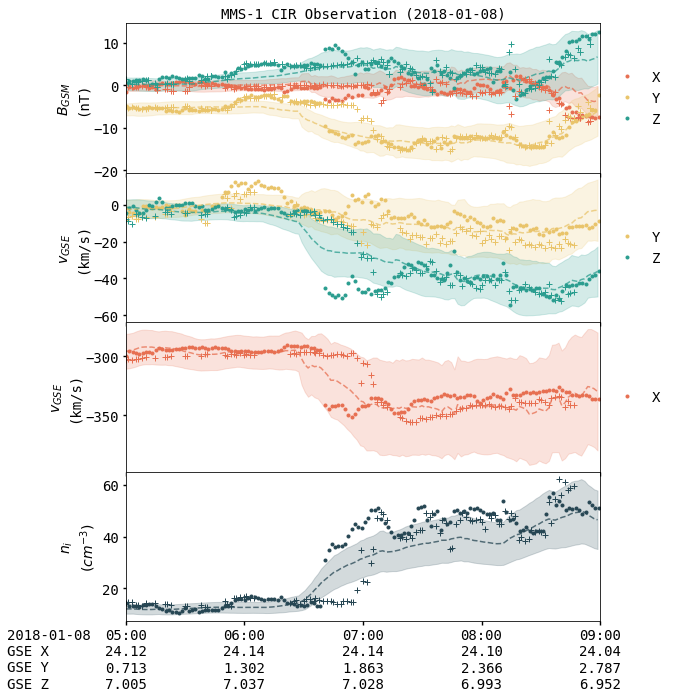

In [7]:
#Set the time range
trange = [pd.to_datetime('2018-01-08 05:00:00+0000'), pd.to_datetime('2018-01-08 09:00:00+0000')]
title = 'MMS-1 CIR Observation'

mms_data_cut = pd.read_hdf('../data/mms_data.h5', key='targets', mode = 'a')
mms_data_cut = mms_data_cut[(mms_data_cut['Epoch'] >= trange[0]) & (mms_data_cut['Epoch'] <= trange[1])]
predict_cut = predict_full[(predict_full['Epoch'] >= trange[0]) & (predict_full['Epoch'] <= trange[1])]
bonus_epochs = pd.DataFrame([], columns=['Epoch'])
#Insert nan rows into predict_cut when there is a gap in Epoch longer than 200 seconds
for i in np.arange(1, len(predict_cut)):
    if (predict_cut['Epoch'].iloc[i] - predict_cut['Epoch'].iloc[i-1]) > pd.Timedelta('600s'):
        bonus_epochs = bonus_epochs.append({'Epoch' : predict_cut['Epoch'].iloc[i-1] + pd.Timedelta('100s')}, ignore_index=True)
predict_cut = predict_cut.append(bonus_epochs)
predict_cut.sort_values('Epoch', inplace=True)
predict_cut.reset_index(drop=True,inplace=True)
omni_cut = omni_full[(omni_full['Epoch'] >= trange[0]) & (omni_full['Epoch'] <= trange[1])]
omni_cut.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ne'}, inplace = True) #Rename columns to match mms_test

#Make the plot
fig, ax = plt.subplots(nrows=7,ncols=1,sharex=True)
fig.subplots_adjust(hspace=0) #Remove space between subplots
fig.set_size_inches(8.5, 11) #Set the size of the figure

#BX GSM
ax[0].plot(mms_data_cut['Epoch'], mms_data_cut['B_xgsm'], '.', color=sw.c1)
ax[0].plot(predict_cut['Epoch'], predict_cut['B_xgsm'], color=sw.c1, alpha=0.75, linestyle = '--')
ax[0].fill_between(predict_cut['Epoch'], predict_cut['B_xgsm'] + predict_cut['B_xgsm_sig'], predict_cut['B_xgsm'] - predict_cut['B_xgsm_sig'], color=sw.c1, alpha=0.2)
ax[0].plot(omni_cut['Epoch'], omni_cut['B_xgsm'], '+', color=sw.c1, alpha=1)
ax[0].set_ylabel(r'$B_{X}$ GSM' 
                    '\n(nT)', fontsize=14)
ax[0].tick_params(axis='y', which='major', labelsize=14)
ax[0].set_title(title + ' ('+trange[0].strftime('%Y-%m-%d')+')', fontsize=14) #Set the title

#BY GSM
ax[1].plot(mms_data_cut['Epoch'], mms_data_cut['B_ygsm'], '.', color=sw.c3)
ax[1].plot(predict_cut['Epoch'], predict_cut['B_ygsm'], color=sw.c3, alpha=0.75, linestyle = '--')
ax[1].fill_between(predict_cut['Epoch'], predict_cut['B_ygsm'] + predict_cut['B_ygsm_sig'], predict_cut['B_ygsm'] - predict_cut['B_ygsm_sig'], color=sw.c3, alpha=0.2)
ax[1].plot(omni_cut['Epoch'], omni_cut['B_ygsm'], '+', color=sw.c3, alpha=1)
ax[1].set_ylabel(r'$B_{Y}$ GSM' 
                    '\n(nT)', fontsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=14)

#BZ GSM
ax[2].plot(mms_data_cut['Epoch'], mms_data_cut['B_zgsm'], '.', color=sw.c4)
ax[2].plot(predict_cut['Epoch'], predict_cut['B_zgsm'], color=sw.c4, alpha=0.75, linestyle = '--')
ax[2].fill_between(predict_cut['Epoch'], predict_cut['B_zgsm'] + predict_cut['B_zgsm_sig'], predict_cut['B_zgsm'] - predict_cut['B_zgsm_sig'], color=sw.c4, alpha=0.2)
ax[2].plot(omni_cut['Epoch'], omni_cut['B_zgsm'], '+', color=sw.c4, alpha=1)
ax[2].set_ylabel(r'$B_{Z}$ GSM' 
                    '\n(nT)', fontsize=14)
ax[2].tick_params(axis='y', which='major', labelsize=14)

#Velocity X plot
ax[3].plot(mms_data_cut['Epoch'], mms_data_cut['Vi_xgse'], '.', color=sw.c1)
ax[3].plot(predict_cut['Epoch'], predict_cut['Vi_xgse'], color=sw.c1, alpha=0.75, linestyle = '--')
ax[3].fill_between(predict_cut['Epoch'], predict_cut['Vi_xgse'] + predict_cut['Vi_xgse_sig'], predict_cut['Vi_xgse'] - predict_cut['Vi_xgse_sig'], color=sw.c1, alpha=0.2)
ax[3].plot(omni_cut['Epoch'], omni_cut['Vi_xgse'], '+', color=sw.c1, alpha=1)
ax[3].set_ylabel(r'$V_{X}$ GSE' 
                    '\n(km/s)', fontsize=14)
ax[3].tick_params(axis='y', which='major', labelsize=14)

#Velocity Y plot
ax[4].plot(mms_data_cut['Epoch'], mms_data_cut['Vi_ygse'], '.', color=sw.c3)
ax[4].plot(predict_cut['Epoch'], predict_cut['Vi_ygse'], color=sw.c3, alpha=0.75, linestyle = '--')
ax[4].fill_between(predict_cut['Epoch'], predict_cut['Vi_ygse'] + predict_cut['Vi_ygse_sig'], predict_cut['Vi_ygse'] - predict_cut['Vi_ygse_sig'], color=sw.c3, alpha=0.2)
ax[4].plot(omni_cut['Epoch'], omni_cut['Vi_ygse'], '+', color=sw.c3, alpha=1)
ax[4].set_ylabel(r'$V_{Y}$ GSE' 
                    '\n(km/s)', fontsize=14)
ax[4].tick_params(axis='y', which='major', labelsize=14)

#Velocity Z plot
ax[5].plot(mms_data_cut['Epoch'], mms_data_cut['Vi_zgse'], '.', color=sw.c4)
ax[5].plot(predict_cut['Epoch'], predict_cut['Vi_zgse'], color=sw.c4, alpha=0.75, linestyle = '--')
ax[5].fill_between(predict_cut['Epoch'], predict_cut['Vi_zgse'] + predict_cut['Vi_zgse_sig'], predict_cut['Vi_zgse'] - predict_cut['Vi_zgse_sig'], color=sw.c4, alpha=0.2)
ax[5].plot(omni_cut['Epoch'], omni_cut['Vi_zgse'], '+', color=sw.c4, alpha=1)
ax[5].set_ylabel(r'$V_{Z}$ GSE' 
                    '\n(km/s)', fontsize=14)
ax[5].tick_params(axis='y', which='major', labelsize=14)

#Density plot
ax[6].plot(mms_data_cut['Epoch'], mms_data_cut['Ne'], '.', color=sw.c5)
ax[6].plot(predict_cut['Epoch'], predict_cut['Ne'], color=sw.c5, alpha=0.75, linestyle = '--')
ax[6].fill_between(predict_cut['Epoch'], predict_cut['Ne'] + predict_cut['Ne_sig'], predict_cut['Ne'] - predict_cut['Ne_sig'], color=sw.c5, alpha=0.2)
ax[6].plot(omni_cut['Epoch'], omni_cut['Ne'], '+', color=sw.c5, alpha=1)
ax[6].set_ylabel(r'$n_{i/e}$'
                    '\n'
                    r'$(cm^{-3})$', fontsize=14)
ax[6].tick_params(axis='y', which='major', labelsize=14)

#Set the x-axis ticks and labels for time and positiong
quart_delt = (trange[1]-trange[0])/4.0
ticks = [trange[0],trange[0]+quart_delt,trange[0]+2*quart_delt,trange[0]+3*quart_delt,trange[1]]
tickstamp = [trange[0].timestamp(),(trange[0]+quart_delt).timestamp(),(trange[0]+2*quart_delt).timestamp(),(trange[0]+3*quart_delt).timestamp(),trange[1].timestamp()]
X_GSE_ticks = np.interp(tickstamp, (mms_data_cut['Epoch'] - pd.Timestamp("1970-01-01 00:00:00+0000")) // pd.Timedelta('1s'), mms_data_cut['R_xgse'])
Y_GSE_ticks = np.interp(tickstamp, (mms_data_cut['Epoch'] - pd.Timestamp("1970-01-01 00:00:00+0000")) // pd.Timedelta('1s'), mms_data_cut['R_ygse'])
Z_GSE_ticks = np.interp(tickstamp, (mms_data_cut['Epoch'] - pd.Timestamp("1970-01-01 00:00:00+0000")) // pd.Timedelta('1s'), mms_data_cut['R_zgse'])
labels = [trange[0].strftime('%H:%M')+'\n'+str(X_GSE_ticks[0])[:5]+'\n'+str(Y_GSE_ticks[0])[:5]+'\n'+str(Z_GSE_ticks[0])[:5],
        (trange[0]+quart_delt).strftime('%H:%M')+'\n'+str(X_GSE_ticks[1])[:5]+'\n'+str(Y_GSE_ticks[1])[:5]+'\n'+str(Z_GSE_ticks[1])[:5],
        (trange[0]+2*quart_delt).strftime('%H:%M')+'\n'+str(X_GSE_ticks[2])[:5]+'\n'+str(Y_GSE_ticks[2])[:5]+'\n'+str(Z_GSE_ticks[2])[:5],
        (trange[0]+3*quart_delt).strftime('%H:%M')+'\n'+str(X_GSE_ticks[3])[:5]+'\n'+str(Y_GSE_ticks[3])[:5]+'\n'+str(Z_GSE_ticks[3])[:5],
        trange[1].strftime('%H:%M')+'\n'+str(X_GSE_ticks[4])[:5]+'\n'+str(Y_GSE_ticks[4])[:5]+'\n'+str(Z_GSE_ticks[4])[:5]]
ax[6].set_xlim(trange[0],trange[1])
ax[6].set_xticks(ticks)
ax[6].set_xticklabels(labels)
ax[6].tick_params(axis='x', which='major', labelsize=14)
ax[6].text(-0.25, -3.775, trange[0].strftime('%Y-%m-%d') + '\nGSE X\nGSE Y\nGSE Z', transform = ax[3].transAxes, fontsize=14)

#plt.savefig(plotpath+'CIR.pdf', transparent = False, bbox_inches = 'tight')

c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


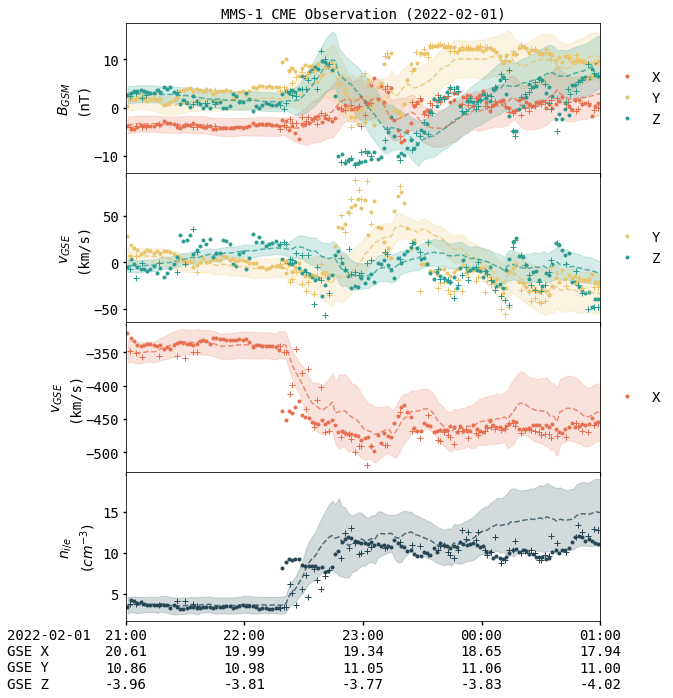

In [29]:
#Set the time range
trange = [pd.to_datetime('2022-02-01 21:00:00+0000'), pd.to_datetime('2022-02-02 01:00:00+0000')]
title = 'MMS-1 CME Observation'

fgm_data = pd.read_hdf('../data/mms_data.h5', key='fgm_raw', mode = 'a')
fgm_cut = fgm_data[(fgm_data['Epoch_fgm'] >= trange[0]) & (fgm_data['Epoch_fgm'] <= trange[1])]
del fgm_data
dis_data = pd.read_hdf('../data/mms_data.h5', key='dis_raw', mode = 'a')
dis_cut = dis_data[(dis_data['Epoch_dis'] >= trange[0]) & (dis_data['Epoch_dis'] <= trange[1])]
del dis_data
des_data = pd.read_hdf('../data/mms_data.h5', key='des_raw', mode = 'a')
des_cut = des_data[(des_data['Epoch_des'] >= trange[0]) & (des_data['Epoch_des'] <= trange[1])]
del des_data
mec_data = pd.read_hdf('../data/mms_data.h5', key='mec_raw', mode = 'a')
mec_cut = mec_data[(mec_data['Epoch_mec'] >= trange[0]) & (mec_data['Epoch_mec'] <= trange[1])]
del mec_data
#Bin the data to 100s to make it comparable to the PRIME data
bins = pd.date_range(trange[0], trange[1], freq='100s')
fgm_cut = fgm_cut.groupby(pd.cut(fgm_cut['Epoch_fgm'], bins)).mean()
fgm_cut.reset_index(inplace=True)
fgm_cut['Epoch_fgm'] = bins[:-1] + pd.Timedelta('50s')
dis_cut = dis_cut.groupby(pd.cut(dis_cut['Epoch_dis'], bins)).mean()
dis_cut.reset_index(inplace=True)
dis_cut['Epoch_dis'] = bins[:-1] + pd.Timedelta('50s')
des_cut = des_cut.groupby(pd.cut(des_cut['Epoch_des'], bins)).mean()
des_cut.reset_index(inplace=True)
des_cut['Epoch_des'] = bins[:-1] + pd.Timedelta('50s')
mec_cut = mec_cut.groupby(pd.cut(mec_cut['Epoch_mec'], bins)).mean()
mec_cut.reset_index(inplace=True)
mec_cut['Epoch_mec'] = bins[:-1] + pd.Timedelta('50s')

ts = pd.Timedelta('1620s') #Trying out a timeshift equal to the stride to see if there's been some error in generating the full dataset
predict_cut = predict_full[(predict_full['Epoch']+ts >= trange[0]) & (predict_full['Epoch']+ts <= trange[1])]
predict_cut['Epoch'] += ts
bonus_epochs = pd.DataFrame([], columns=['Epoch'])
#Insert nan rows into predict_cut when there is a gap in Epoch longer than 200 seconds
for i in np.arange(1, len(predict_cut)):
    if (predict_cut['Epoch'].iloc[i] - predict_cut['Epoch'].iloc[i-1]) > pd.Timedelta('600s'):
        bonus_epochs = bonus_epochs.append({'Epoch' : predict_cut['Epoch'].iloc[i-1] + pd.Timedelta('100s')}, ignore_index=True)
predict_cut = predict_cut.append(bonus_epochs)
predict_cut.sort_values('Epoch', inplace=True)
predict_cut.reset_index(drop=True,inplace=True)
omni_cut = omni_full[(omni_full['Epoch'] >= trange[0]) & (omni_full['Epoch'] <= trange[1])]
omni_cut.rename(columns = {'BX_GSE':'B_xgsm', 'BY_GSM':'B_ygsm', 'BZ_GSM':'B_zgsm', 'VX_GSE':'Vi_xgse', 'VY_GSE':'Vi_ygse', 'VZ_GSE':'Vi_zgse', 'proton_density':'Ne'}, inplace = True) #Rename columns to match mms_test

#Make the plot
fig, ax = plt.subplots(nrows=7,ncols=1,sharex=True)
fig.subplots_adjust(hspace=0) #Remove space between subplots
fig.set_size_inches(8.5, 11) #Set the size of the figure

#BX GSM
ax[0].plot(fgm_cut['Epoch_fgm'], fgm_cut['Bx_gsm'], '.', color=sw.c1)
ax[0].plot(predict_cut['Epoch'], predict_cut['B_xgsm'], color=sw.c1, alpha=0.75, linestyle = '--')
ax[0].fill_between(predict_cut['Epoch'], predict_cut['B_xgsm'] + predict_cut['B_xgsm_sig'], predict_cut['B_xgsm'] - predict_cut['B_xgsm_sig'], color=sw.c1, alpha=0.2)
ax[0].plot(omni_cut['Epoch'], omni_cut['B_xgsm'], '+', color=sw.c1, alpha=1)
ax[0].set_ylabel(r'$B_{X}$ GSM' 
                    '\n(nT)', fontsize=14)
ax[0].tick_params(axis='y', which='major', labelsize=14)
ax[0].set_title(title + ' ('+trange[0].strftime('%Y-%m-%d')+')', fontsize=14) #Set the title

#BY GSM
ax[1].plot(fgm_cut['Epoch_fgm'], fgm_cut['By_gsm'], '.', color=sw.c3)
ax[1].plot(predict_cut['Epoch'], predict_cut['B_ygsm'], color=sw.c3, alpha=0.75, linestyle = '--')
ax[1].fill_between(predict_cut['Epoch'], predict_cut['B_ygsm'] + predict_cut['B_ygsm_sig'], predict_cut['B_ygsm'] - predict_cut['B_ygsm_sig'], color=sw.c3, alpha=0.2)
ax[1].plot(omni_cut['Epoch'], omni_cut['B_ygsm'], '+', color=sw.c3, alpha=1)
ax[1].set_ylabel(r'$B_{Y}$ GSM' 
                    '\n(nT)', fontsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=14)

#BZ GSM
ax[2].plot(fgm_cut['Epoch_fgm'], fgm_cut['Bz_gsm'], '.', color=sw.c4)
ax[2].plot(predict_cut['Epoch'], predict_cut['B_zgsm'], color=sw.c4, alpha=0.75, linestyle = '--')
ax[2].fill_between(predict_cut['Epoch'], predict_cut['B_zgsm'] + predict_cut['B_zgsm_sig'], predict_cut['B_zgsm'] - predict_cut['B_zgsm_sig'], color=sw.c4, alpha=0.2)
ax[2].plot(omni_cut['Epoch'], omni_cut['B_zgsm'], '+', color=sw.c4, alpha=1)
ax[2].set_ylabel(r'$B_{Z}$ GSM' 
                    '\n(nT)', fontsize=14)
ax[2].tick_params(axis='y', which='major', labelsize=14)

#Velocity X plot
ax[3].plot(dis_cut['Epoch_dis'], dis_cut['Vi_xgse'], '.', color=sw.c1)
ax[3].plot(predict_cut['Epoch'], predict_cut['Vi_xgse'], color=sw.c1, alpha=0.75, linestyle = '--')
ax[3].fill_between(predict_cut['Epoch'], predict_cut['Vi_xgse'] + predict_cut['Vi_xgse_sig'], predict_cut['Vi_xgse'] - predict_cut['Vi_xgse_sig'], color=sw.c1, alpha=0.2)
ax[3].plot(omni_cut['Epoch'], omni_cut['Vi_xgse'], '+', color=sw.c1, alpha=1)
ax[3].set_ylabel(r'$V_{X}$ GSE' 
                    '\n(km/s)', fontsize=14)
ax[3].tick_params(axis='y', which='major', labelsize=14)

#Velocity Y plot
ax[4].plot(dis_cut['Epoch_dis'], dis_cut['Vi_ygse']-29, '.', color=sw.c3)
ax[4].plot(predict_cut['Epoch'], predict_cut['Vi_ygse'], color=sw.c3, alpha=0.75, linestyle = '--')
ax[4].fill_between(predict_cut['Epoch'], predict_cut['Vi_ygse'] + predict_cut['Vi_ygse_sig'], predict_cut['Vi_ygse'] - predict_cut['Vi_ygse_sig'], color=sw.c3, alpha=0.2)
ax[4].plot(omni_cut['Epoch'], omni_cut['Vi_ygse'], '+', color=sw.c3, alpha=1)
ax[4].set_ylabel(r'$V_{Y}$ GSE' 
                    '\n(km/s)', fontsize=14)
ax[4].tick_params(axis='y', which='major', labelsize=14)

#Velocity Z plot
ax[5].plot(dis_cut['Epoch_dis'], dis_cut['Vi_zgse'], '.', color=sw.c4)
ax[5].plot(predict_cut['Epoch'], predict_cut['Vi_zgse'], color=sw.c4, alpha=0.75, linestyle = '--')
ax[5].fill_between(predict_cut['Epoch'], predict_cut['Vi_zgse'] + predict_cut['Vi_zgse_sig'], predict_cut['Vi_zgse'] - predict_cut['Vi_zgse_sig'], color=sw.c4, alpha=0.2)
ax[5].plot(omni_cut['Epoch'], omni_cut['Vi_zgse'], '+', color=sw.c4, alpha=1)
ax[5].set_ylabel(r'$V_{Z}$ GSE' 
                    '\n(km/s)', fontsize=14)
ax[5].tick_params(axis='y', which='major', labelsize=14)

#Density plot
ax[6].plot(des_cut['Epoch_des'], des_cut['Ne'], '.', color=sw.c5)
ax[6].plot(predict_cut['Epoch'], predict_cut['Ne'], color=sw.c5, alpha=0.75, linestyle = '--')
ax[6].fill_between(predict_cut['Epoch'], predict_cut['Ne'] + predict_cut['Ne_sig'], predict_cut['Ne'] - predict_cut['Ne_sig'], color=sw.c5, alpha=0.2)
ax[6].plot(omni_cut['Epoch'], omni_cut['Ne'], '+', color=sw.c5, alpha=1)
ax[6].set_ylabel(r'$n_{i/e}$'
                    '\n'
                    r'$(cm^{-3})$', fontsize=14)
ax[6].tick_params(axis='y', which='major', labelsize=14)

#Set the x-axis ticks and labels for time and positiong
quart_delt = (trange[1]-trange[0])/4.0
ticks = [trange[0],trange[0]+quart_delt,trange[0]+2*quart_delt,trange[0]+3*quart_delt,trange[1]]
tickstamp = [trange[0].timestamp(),(trange[0]+quart_delt).timestamp(),(trange[0]+2*quart_delt).timestamp(),(trange[0]+3*quart_delt).timestamp(),trange[1].timestamp()]
X_GSE_ticks = np.interp(tickstamp, (mms_data_cut['Epoch'] - pd.Timestamp("1970-01-01 00:00:00+0000")) // pd.Timedelta('1s'), mms_data_cut['R_xgse'])
Y_GSE_ticks = np.interp(tickstamp, (mms_data_cut['Epoch'] - pd.Timestamp("1970-01-01 00:00:00+0000")) // pd.Timedelta('1s'), mms_data_cut['R_ygse'])
Z_GSE_ticks = np.interp(tickstamp, (mms_data_cut['Epoch'] - pd.Timestamp("1970-01-01 00:00:00+0000")) // pd.Timedelta('1s'), mms_data_cut['R_zgse'])
labels = [trange[0].strftime('%H:%M')+'\n'+str(X_GSE_ticks[0])[:5]+'\n'+str(Y_GSE_ticks[0])[:5]+'\n'+str(Z_GSE_ticks[0])[:5],
        (trange[0]+quart_delt).strftime('%H:%M')+'\n'+str(X_GSE_ticks[1])[:5]+'\n'+str(Y_GSE_ticks[1])[:5]+'\n'+str(Z_GSE_ticks[1])[:5],
        (trange[0]+2*quart_delt).strftime('%H:%M')+'\n'+str(X_GSE_ticks[2])[:5]+'\n'+str(Y_GSE_ticks[2])[:5]+'\n'+str(Z_GSE_ticks[2])[:5],
        (trange[0]+3*quart_delt).strftime('%H:%M')+'\n'+str(X_GSE_ticks[3])[:5]+'\n'+str(Y_GSE_ticks[3])[:5]+'\n'+str(Z_GSE_ticks[3])[:5],
        trange[1].strftime('%H:%M')+'\n'+str(X_GSE_ticks[4])[:5]+'\n'+str(Y_GSE_ticks[4])[:5]+'\n'+str(Z_GSE_ticks[4])[:5]]
ax[6].set_xlim(trange[0],trange[1])
ax[6].set_xticks(ticks)
ax[6].set_xticklabels(labels)
ax[6].tick_params(axis='x', which='major', labelsize=14)
ax[6].text(-0.25, -3.775, trange[0].strftime('%Y-%m-%d') + '\nGSE X\nGSE Y\nGSE Z', transform = ax[3].transAxes, fontsize=14)

#plt.savefig(plotpath+'CME.pdf', transparent = False, bbox_inches = 'tight')

c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


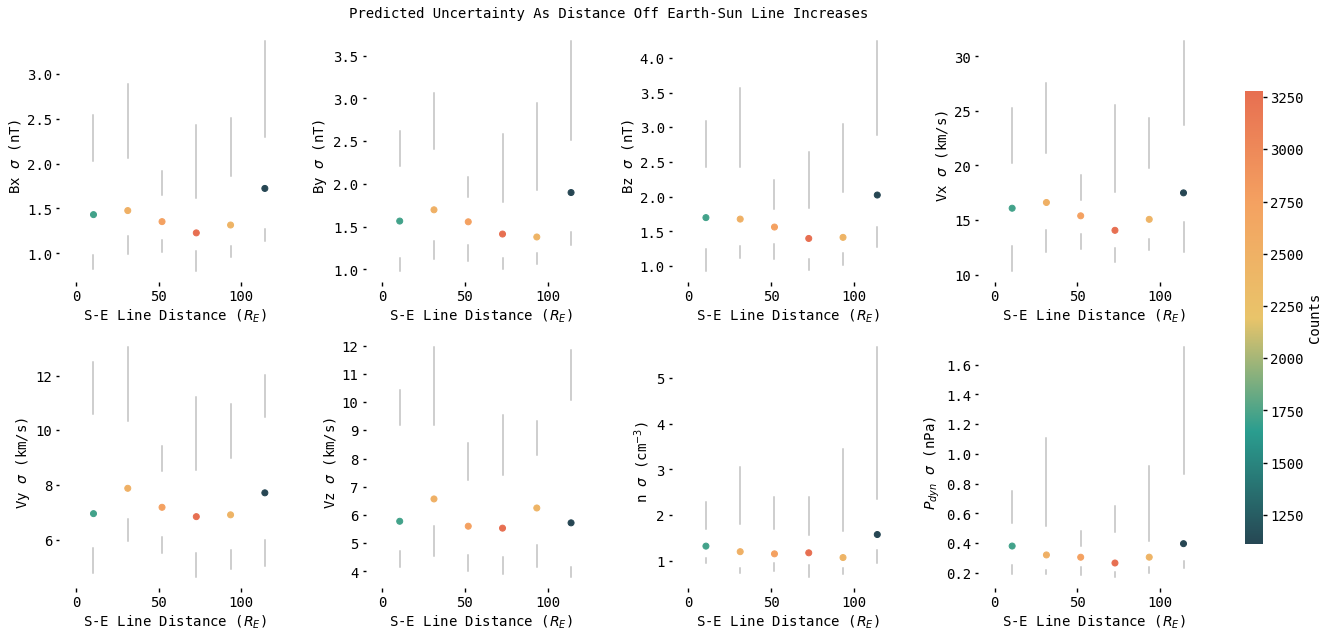

In [10]:
#Plot PRIME's performance (CRPS) in GSE coordinates
fig = plt.figure(figsize=(20,10))
fig.suptitle('PRIME CRPS on Test Dataset', fontsize = 20)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(mms_test['R_xgse'], mms_test['R_ygse'], mms_test['R_zgse'], '.', s = 0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), norm = LogNorm(), label = 'SW Test', cmap = taikonaut)
ax.set_proj_type('ortho')
#Make 3d scatter facecolor white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#Remove 3d scatter axis lines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

#ax.plot(wind_data['Px_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Py_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, wind_data['Pz_gse'][wind_data['flag'] != 1]/sw.EARTH_RADIUS, '.', markersize = 0.5, c = c1, label = 'Wind Inputs')
ax.set_xlabel('X GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='x', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_ylabel('Y GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='y', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_zlabel('Z GSE ($R_{E}$)', fontsize = 16)
ax.tick_params(axis='z', labelsize=16, color="#b0b0b0", width = 0.4)
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)
#ax.legend(fontsize = 14, loc = 'upper left')

ax2 = fig.add_subplot(122)
scatter = ax2.scatter(mms_test['R_ygse'], mms_test['R_xgse'], s=0.5, c=np.mean(predict_error[keys]/np.std(mms_train[keys]), axis=1), norm = LogNorm(), cmap = taikonaut)
ax2.set_aspect('equal')
ax2.set_ylim(0, 30)
ax2.set_ylabel(r'X GSE ($R_{E}$)', fontsize = 16)
ax2.set_xlim(30, -30)
ax2.set_xlabel(r'Y GSE ($R_{E}$)', fontsize = 16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#Add colorbar for scatterplot points on the right side of the figure
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label(r'CRPS $\sigma$',fontsize = 16)
cbar.ax.tick_params(labelsize=16)  
#plt.savefig('../plots/crps_3d.pdf', bbox_inches = 'tight')

In [ ]:
#Calculate the correlation coefficient for 10 minute segments of mms data and predicted data
segments = pd.date_range(start='2015-09-02 00:00:00+0000', end='2021-04-21 00:00:00+0000', freq='10min')
record = pd.DataFrame(columns = ['Epoch', 'r_prime', 'n_prime', 'r_omni', 'n_omni'])
for i in range(len(segments)-1):
    start = segments[i]
    end = segments[i+1]
    mms_segment = mms_test.loc[(mms_test['Epoch'] >= start) & (mms_test['Epoch'] < end)]
    pred_segment = predict_test.loc[(predict_test['Epoch'] >= start) & (predict_test['Epoch'] < end)]
    omni_segment = omni_test.loc[(omni_test['Epoch'] >= start) & (omni_test['Epoch'] < end)]
    r_prime = mms_segment['theta'].corr(pred_segment['theta'])
    n_prime = len(pred_segment.dropna())
    r_omni = mms_segment['theta'].corr(omni_segment['theta'])
    n_omni = len(omni_segment.dropna())
    record = record.append({'Epoch': start, 'r_prime': r_prime, 'n_prime': n_prime, 'r_omni': r_omni, 'n_omni': n_omni}, ignore_index=True)
    print('% Complete: '+str(round(i/len(segments)*100, 2)), end='\r')

In [ ]:
bins = np.linspace(0,1,20)
r_prime_cut = record['r_prime'][record['n_prime'] == 6].abs().dropna()
r_omni_cut = record['r_omni'][record['n_omni'] == 6].abs().dropna()
prime_percents = 100*sps.binned_statistic(r_prime_cut, r_prime_cut, bins=bins, statistic='count')[0]/len(r_prime_cut)
omni_percents = 100*sps.binned_statistic(r_omni_cut, r_omni_cut, bins=bins, statistic='count')[0]/len(r_omni_cut)
plt.figure(figsize=(7,7))
plt.bar(bins[:-1], omni_percents, width=bins[1]-bins[0], align='edge', label='MVA Wind', alpha=0.5, color = c1)
plt.bar(bins[:-1], prime_percents, width=bins[1]-bins[0], align='edge', label='Prime', alpha=0.5, color = c4)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Percent Occurrence')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.title(r'10-Minute Correlations Between Predicted and MMS-Measured IMF $\theta_{C}$', fontsize=14)
#plt.savefig(plotpath+'timingaccuracy.pdf', dpi=300, bbox_inches='tight')

In [ ]:
wind_test_ind = ksc.closest_argmin((predict_test['Epoch']-pd.Timedelta('1800s')).to_numpy(), wind_data['Epoch'].to_numpy())
wind_test = wind_data.iloc[wind_test_ind]
wind_test.index = predict_test.index
wind_test['sc_sep'] = np.sqrt((wind_test['R_xgse'] - wind_test['target_R_xgse'])**2 + (wind_test['R_ygse'] - wind_test['target_R_ygse'])**2 + (wind_test['R_zgse'] - wind_test['target_R_zgse'])**2)
wind_test['sc_sep_tan'] = np.sqrt((wind_test['R_ygse'] - wind_test['target_R_ygse'])**2 + (wind_test['R_zgse'] - wind_test['target_R_zgse'])**2)
wind_test['B_xgsm_sig'] = np.nan #Initialize the standard deviation of the magnetic field in the x direction
wind_test['B_ygsm_sig'] = np.nan #Initialize the standard deviation of the magnetic field in the y direction
wind_test['B_zgsm_sig'] = np.nan #Initialize the standard deviation of the magnetic field in the z direction
for i, idx in enumerate(wind_test.index):
    wind_time = wind_test.loc[idx, 'Epoch']
    wind_test.loc[idx, 'B_xgsm_sig'] = np.std(wind_data.loc[(wind_data['Epoch'] > wind_time - pd.Timedelta('5000s')) & (wind_data['Epoch'] < wind_time), 'B_xgsm'].to_numpy())
    wind_test.loc[idx, 'B_ygsm_sig'] = np.std(wind_data.loc[(wind_data['Epoch'] > wind_time - pd.Timedelta('5000s')) & (wind_data['Epoch'] < wind_time), 'B_ygsm'].to_numpy())
    wind_test.loc[idx, 'B_zgsm_sig'] = np.std(wind_data.loc[(wind_data['Epoch'] > wind_time - pd.Timedelta('5000s')) & (wind_data['Epoch'] < wind_time), 'B_zgsm'].to_numpy())
    print(100*i/len(wind_test.index), end='\r')
wind_test['V'] = np.sqrt(wind_test['Vi_xgse']**2 + wind_test['Vi_ygse']**2 + wind_test['Vi_zgse']**2)

#plot the uncertainty of each parameter as a function of spacecraft separation
fig, ax = plt.subplots(2, 4, figsize = (17, 9)) #Create the figure
fig.subplots_adjust(hspace = 0.40, wspace=0.35)
fig.suptitle('Predicted Uncertainty As Distance Off Earth-Sun Line Increases', fontsize=14) #add title to figure
sig_keys = ['B_xgsm_sig', 'B_ygsm_sig', 'B_zgsm_sig', 'Vi_xgse_sig', 'Vi_ygse_sig', 'Vi_zgse_sig', 'Ne_sig', 'pdyn_sig'] #Keys for the data parameters to be compared
sig_labels = ['Bx $\sigma$ (nT)', 'By $\sigma$ (nT)', 'Bz $\sigma$ (nT)', 'Vx $\sigma$ (km/s)', 'Vy $\sigma$ (km/s)', 'Vz $\sigma$ (km/s)', 'n $\sigma$ (cm$^{-3}$)', '$P_{dyn}$ $\sigma$ (nPa)'] #Labels for the data parameters to be compared
xbounds = [[0,120], [0,120], [0,120], [0,120], [0,120], [0,120], [0,120], [0,120]] #Bounds for the x axis
#ybounds = [[0.5,3], [0.5,3], [0.5,3], [5,25], [0,15], [0,15], [0,2.5], [0,2]] #Bounds for the y axis
nbins = 6 #Number of bins
for i in range(2):
    for j in range(4):
        #Calculate percentiles for each bin
        predict_10, bins, _ = sps.binned_statistic(wind_test['sc_sep_tan'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 10)) #Calculate the 10th percentile for each bin (GRU)
        predict_25, bins, _ = sps.binned_statistic(wind_test['sc_sep_tan'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 25)) #Calculate the 25th percentile for each bin (GRU)
        predict_50, bins, _ = sps.binned_statistic(wind_test['sc_sep_tan'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 50)) #Calculate the 50th percentile for each bin (GRU)
        predict_75, bins, _ = sps.binned_statistic(wind_test['sc_sep_tan'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 75)) #Calculate the 75th percentile for each bin (GRU)
        predict_90, bins, _ = sps.binned_statistic(wind_test['sc_sep_tan'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 90)) #Calculate the 90th percentile for each bin (GRU)
        
        predict_mean, bins, _ = sps.binned_statistic(wind_test['sc_sep_tan'], np.abs(predict_test[sig_keys[i*4+j]]), bins = nbins, statistic = 'mean') #Calculate the mean error for each bin (GRU)
        predict_count, bins, _ = sps.binned_statistic(wind_test['sc_sep_tan'], np.abs(predict_test[sig_keys[i*4+j]]), bins = nbins, statistic = 'count') #Calculate the number of points in each bin (GRU)

        scatter = ax[i, j].scatter(bins[:-1]+0.5*(bins[1]-bins[0]), predict_50, c = predict_count, label = 'Median $\sigma$', cmap = taikonaut) #Plot the median error in each bin (GRU)
        #Plot vertical line between 75th and 90th percentile for each bin
        for k in range(nbins):
            #Plot vertical line between 75th and 90th percentile for each bin
            ax[i, j].plot([bins[k]+0.5*(bins[1]-bins[0]), bins[k]+0.5*(bins[1]-bins[0])], [predict_75[k], predict_90[k]], color = 'grey', alpha = 0.5)
            #Plot vertical line between 25th and 10th percentile for each bin
            ax[i, j].plot([bins[k]+0.5*(bins[1]-bins[0]), bins[k]+0.5*(bins[1]-bins[0])], [predict_25[k], predict_10[k]], color = 'grey', alpha = 0.5)
        ax[i, j].set_xlabel('S-E Line Distance ($R_{E}$)') #Set the x-axis label
        ax[i, j].set_ylabel(sig_labels[i*4+j]) #Set the y-axis label
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['bottom'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
        ax[i, j].set_xlim(xbounds[i*4+j][0]-10, xbounds[i*4+j][1]+10) #Set the x-axis limits
        #ax[i, j].set_ylim(ybounds[i*4+j][0], ybounds[i*4+j][1]) #Set the y-axis limits
#Add colorbar for scatterplot points on the right side of the figure
cbar_ax = fig.add_axes([1.02, 0.15, 0.015, 0.7]) #Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax = cbar_ax) #Add the colorbar
cbar.outline.set_visible(False) #Remove the colorbar outline
cbar.set_label('Counts') #Add a label to the colorbar
plt.tight_layout() #Adjust the layout
#plt.savefig('../plots/bin_error_sep.pdf', bbox_inches = 'tight') #Save the plot

c:\Users\conno\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


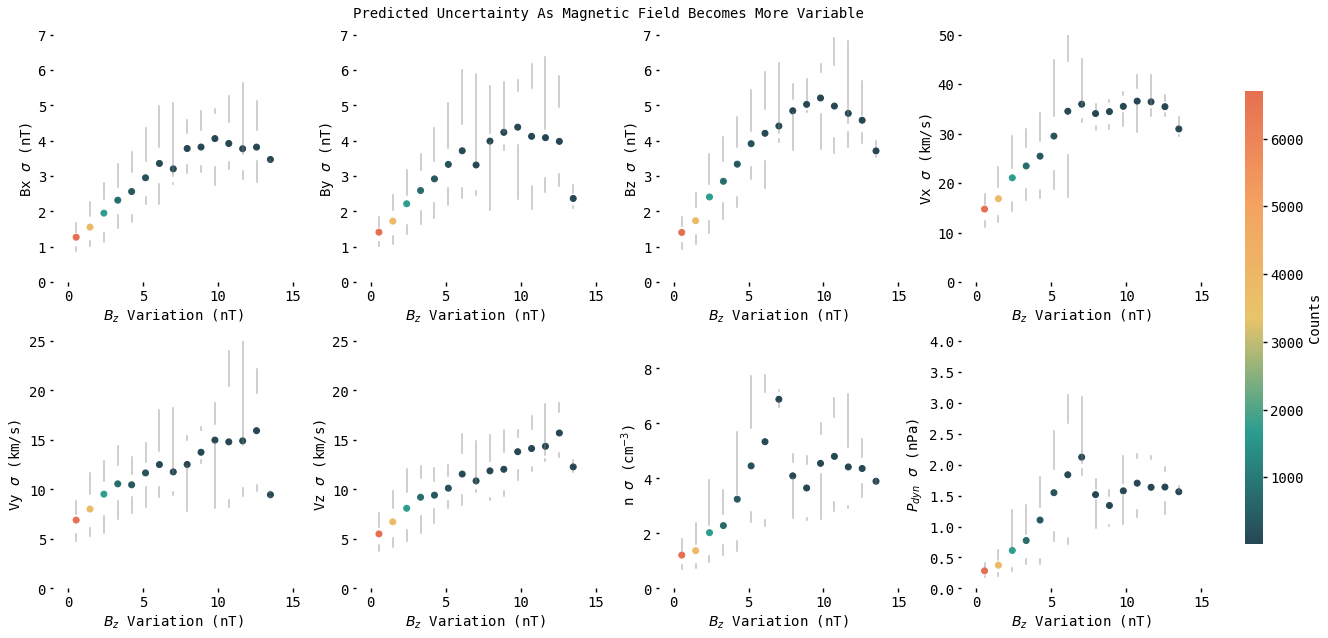

In [12]:
#plot the uncertainty of each parameter as a function of magnetic field variation
fig, ax = plt.subplots(2, 4, figsize = (17, 9)) #Create the figure
fig.subplots_adjust(hspace = 0.40, wspace=0.35)
fig.suptitle('Predicted Uncertainty As Magnetic Field Becomes More Variable', fontsize=14) #add title to figure
sig_keys = ['B_xgsm_sig', 'B_ygsm_sig', 'B_zgsm_sig', 'Vi_xgse_sig', 'Vi_ygse_sig', 'Vi_zgse_sig', 'Ne_sig', 'pdyn_sig'] #Keys for the data parameter uncertainties to be compared
sig_labels = ['Bx $\sigma$ (nT)', 'By $\sigma$ (nT)', 'Bz $\sigma$ (nT)', 'Vx $\sigma$ (km/s)', 'Vy $\sigma$ (km/s)', 'Vz $\sigma$ (km/s)', 'n $\sigma$ (cm$^{-3}$)', '$P_{dyn}$ $\sigma$ (nPa)'] #Labels for the data parameters to be compared
xbounds = [[0,14], [0,14], [0,14], [0,14], [0,14], [0,14], [0,14], [0,14]] #Bounds for the x axis
ybounds = [[0,7], [0,7], [0,7], [0,50], [0,25], [0,25], [0,9], [0,4]] #Bounds for the y axis
nbins = 15 #Number of bins
for i in range(2):
    for j in range(4):
        #Calculate percentiles for each bin
        predict_10, bins, _ = sps.binned_statistic(wind_test['B_zgsm_sig'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 10)) #Calculate the 10th percentile for each bin (GRU)
        predict_25, bins, _ = sps.binned_statistic(wind_test['B_zgsm_sig'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 25)) #Calculate the 25th percentile for each bin (GRU)
        predict_50, bins, _ = sps.binned_statistic(wind_test['B_zgsm_sig'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 50)) #Calculate the 50th percentile for each bin (GRU)
        predict_75, bins, _ = sps.binned_statistic(wind_test['B_zgsm_sig'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 75)) #Calculate the 75th percentile for each bin (GRU)
        predict_90, bins, _ = sps.binned_statistic(wind_test['B_zgsm_sig'], predict_test[sig_keys[i*4+j]], bins = nbins, statistic = lambda x: np.percentile(x, 90)) #Calculate the 90th percentile for each bin (GRU)
        
        predict_mean, bins, _ = sps.binned_statistic(wind_test['B_zgsm_sig'], np.abs(predict_test[sig_keys[i*4+j]]), bins = nbins, statistic = 'mean') #Calculate the mean error for each bin (GRU)
        predict_count, bins, _ = sps.binned_statistic(wind_test['B_zgsm_sig'], np.abs(predict_test[sig_keys[i*4+j]]), bins = nbins, statistic = 'count') #Calculate the number of points in each bin (GRU)

        scatter = ax[i, j].scatter(bins[:-1]+0.5*(bins[1]-bins[0]), predict_mean, c = predict_count, label = 'Median $\sigma$', cmap = taikonaut) #Plot the median error in each bin (GRU)
        #Plot vertical line between 75th and 90th percentile for each bin
        for k in range(nbins):
            #Plot vertical line between 75th and 90th percentile for each bin
            ax[i, j].plot([bins[k]+0.5*(bins[1]-bins[0]), bins[k]+0.5*(bins[1]-bins[0])], [predict_75[k], predict_90[k]], color = 'grey', alpha = 0.5)
            #Plot vertical line between 25th and 10th percentile for each bin
            ax[i, j].plot([bins[k]+0.5*(bins[1]-bins[0]), bins[k]+0.5*(bins[1]-bins[0])], [predict_25[k], predict_10[k]], color = 'grey', alpha = 0.5)
        ax[i, j].set_xlabel('$B_{z}$ Variation (nT)') #Set the x-axis label
        ax[i, j].set_ylabel(sig_labels[i*4+j]) #Set the y-axis label
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['bottom'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
        ax[i, j].set_xlim(xbounds[i*4+j][0]-1, xbounds[i*4+j][1]+1) #Set the x-axis limits
        ax[i, j].set_ylim(ybounds[i*4+j][0], ybounds[i*4+j][1]) #Set the y-axis limits
#Add colorbar for scatterplot points on the right side of the figure
cbar_ax = fig.add_axes([1.02, 0.15, 0.015, 0.7]) #Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax = cbar_ax) #Add the colorbar
cbar.outline.set_visible(False) #Remove the colorbar outline
cbar.set_label('Counts') #Add a label to the colorbar
plt.tight_layout() #Adjust the layout
#plt.savefig('../plots/bin_error_bz.pdf', bbox_inches = 'tight') #Save the plot

In [ ]:
hps = pd.read_hdf('../modelstore/hyperparameters_2.h5', key = 'sw_hp_20230519', mode = 'a')
#Scatter plot of window and stride colored by val_loss and sized according to fraction
fig = plt.figure(figsize = (4.5, 7))
dotsize = 2000 #Size of the outer dot
steps = [1/2, 1/6] #Steps for the inner dots
scatter = plt.scatter(hps['window'][hps['fraction']==0.15], hps['stride'][hps['fraction']==0.15], c = hps['val_loss'][hps['fraction']==0.15], cmap = taikonaut, s = dotsize, vmax=0.1925, vmin=0.1740)
plt.scatter(hps['window'][hps['fraction']==0.10], hps['stride'][hps['fraction']==0.10], c = hps['val_loss'][hps['fraction']==0.10], cmap = taikonaut, s = dotsize*steps[0], vmax=0.1925, vmin=0.1740)
plt.scatter(hps['window'][hps['fraction']==0.05], hps['stride'][hps['fraction']==0.05], c = hps['val_loss'][hps['fraction']==0.05], cmap = taikonaut, s = dotsize*steps[1], vmax=0.1925, vmin=0.1740)
plt.xlabel('Window Size')
plt.xticks(hps['window'].unique())
plt.xlim(hps['window'].unique().min()-3.5, hps['window'].unique().max()+3.5)
plt.ylabel('Stride')
plt.yticks(hps['stride'].unique())
plt.ylim(hps['stride'].unique().min()-1, hps['stride'].unique().max()+1)
plt.title('Input Dataset Hyperparameters', fontsize = 18)
#Remove ticks and spines
plt.gca().tick_params(axis='both', which='major', labelsize=14, color = 'white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
cbar_ax = fig.add_axes([1.02, 0.4, 0.015, 0.5]) #Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax = cbar_ax) #Add the colorbar
cbar.set_ticks([0.1750, 0.1800, 0.1850, 0.190])
cbar.outline.set_visible(False) #Remove the colorbar outline
cbar.set_label('CRPS Validation Loss') #Add a label to the colorbar

plt.tight_layout()
#plt.savefig('../plots/dataset_hyperparameters.pdf', bbox_inches = 'tight') #Save the plot